In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import random
import matplotlib.pyplot as plt

from models.simple_mlp import SimpleMLP
from utils.run_baselines import run_models, evaluate_results
from embedding import load_embeddings_safetensors

%load_ext autoreload
%autoreload 2

## Define Data and Scope


In [14]:
DATA_PATH_PRETRAIN = "./outputs/embeddings/esm2-facebook/embedding-uniref50-random-35M-avg.safetensors"
DATA_PATH_POSTTRAIN = "./outputs/embeddings/esm2-facebook/embedding-newly-discovered-35M-avg.safetensors"

PRETRAIN_SAMPLE_SIZE = 10000 # 1237

MODELS = {
    "KNN": KNeighborsClassifier(n_neighbors=5, metric='cosine'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Predictor": DummyClassifier(strategy="uniform"),
    "Simple MLP": SimpleMLP(input_size=480, hidden_size=512, layer_count=3, dropout=0.3)
}


In [15]:

pre_training_embeddings, pre_training_ids = load_embeddings_safetensors(DATA_PATH_PRETRAIN)

pre_training_idx = random.sample(list(range(len(pre_training_embeddings))), PRETRAIN_SAMPLE_SIZE)

pre_training_embeddings = pre_training_embeddings[pre_training_idx]
pre_training_ids = [pre_training_ids[i] for i in pre_training_idx]



post_training_embeddings, post_training_ids = load_embeddings_safetensors(DATA_PATH_POSTTRAIN)

print(f"Pretrain embeddings : {pre_training_embeddings.shape}, Posttrain embeddings : {post_training_embeddings.shape}")

Pretrain embeddings : torch.Size([10000, 480]), Posttrain embeddings : torch.Size([1237, 480])


## Run Fitting and Evaluations

In [16]:
results = run_models(MODELS, pre_training_embeddings, post_training_embeddings)

Total samples: 11237, Pre-train: 10000, Post-train: 1237
Completed fold 1/5
Completed fold 2/5
Completed fold 3/5
Completed fold 4/5
Completed fold 5/5
All models evaluated.


In [21]:
stats = evaluate_results(results)
for model_name, stat in stats.items():
    print(f"{model_name}: AUC = {stat['auc']:.4f}, Balanced Accuracy = {stat['balanced_accuracy']:.4f}, Precision = {stat['precision']:.4f}, Recall = {stat['recall']:.4f}")

KNN: AUC = 0.9037, Balanced Accuracy = 0.8202, Precision = 0.7677, Recall = 0.6653
Logistic Regression: AUC = 0.9329, Balanced Accuracy = 0.7614, Precision = 0.7739, Recall = 0.5424
SVM: AUC = 0.9160, Balanced Accuracy = 0.7273, Precision = 0.7532, Recall = 0.4737
Random Predictor: AUC = 0.5000, Balanced Accuracy = 0.5000, Precision = 0.1101, Recall = 1.0000
Simple MLP: AUC = 0.9867, Balanced Accuracy = 0.9175, Precision = 0.9206, Recall = 0.8440


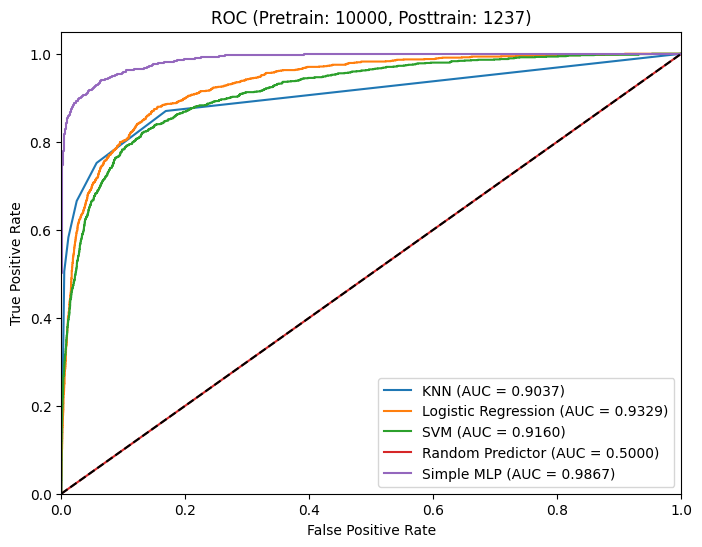

In [ ]:
plt.figure(figsize=(8, 6))
for model_name, stat in stats.items():
    plt.plot(stat['fpr'], stat['tpr'], label=f"{model_name} (AUC = {stat['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC (Pretrain: {len(pre_training_embeddings)}, Posttrain: {len(post_training_embeddings)})')
plt.legend(loc="lower right")
plt.show()
    

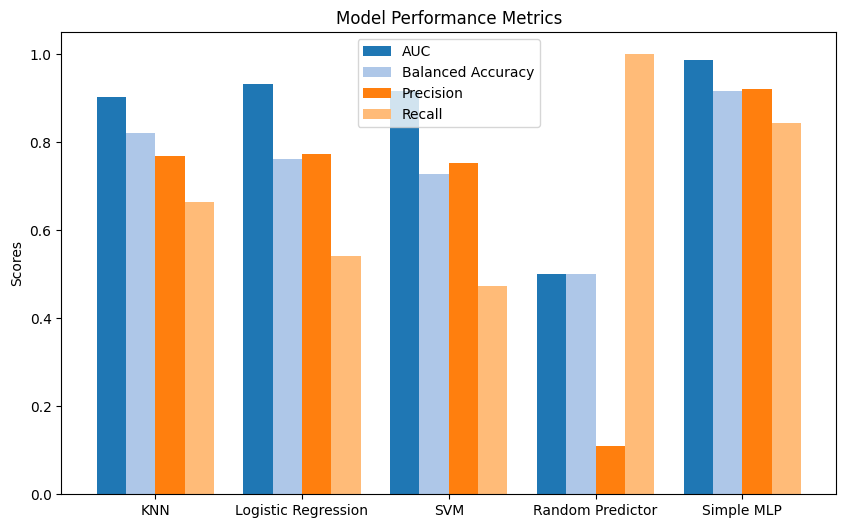

In [ ]:
model_names = list(stats.keys())
auc_scores = [stat['auc'] for stat in stats.values()]
balanced_accuracies = [stat['balanced_accuracy'] for stat in stats.values()]
precisions = [stat['precision'] for stat in stats.values()]
recalls = [stat['recall'] for stat in stats.values()]

colours = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78']

x = np.arange(len(model_names))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, auc_scores, width, label='AUC', color=colours[0])
rects2 = ax.bar(x - 0.5*width, balanced_accuracies, width, label='Balanced Accuracy', color=colours[1])
rects3 = ax.bar(x + 0.5*width, precisions, width, label='Precision', color=colours[2])
rects4 = ax.bar(x + 1.5*width, recalls, width, label='Recall', color=colours[3]) 
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()